# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

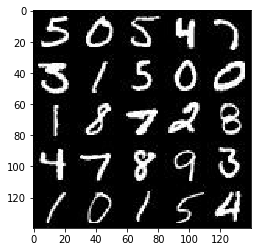

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

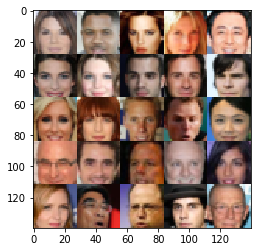

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    l_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_images, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #image is 28x28x3        
        
        #Tried first without the xavier initialization. It seems to perform OK without it
        #Added Xavier initialization since in my other GAN exercises leaving the default 
        #caused erratic runs and difficult when converging
        
        #First Convolution
        conv1 = tf.layers.conv2d(images, 128, 5, 2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * conv1, conv1)
        #14x14x64
        
        #Second Convolution
        conv2 = tf.layers.conv2d(relu1, 256, 5, 2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch2, batch2)
        #7x7x128
        
        #Third Convolution
        conv3 = tf.layers.conv2d(relu2, 512, 5, 2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch3, batch3)
        #4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        dense = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start convolutionals
        conv1 = tf.reshape(dense, (-1, 7, 7, 512))
        batch1 = tf.layers.batch_normalization(conv1, training=is_train)
        relu1 = tf.maximum(alpha * batch1, batch1)
        # 7x7x512
        
        #Second Conv
        conv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * batch2, batch2)
        # 14x14x256
        
        #Third Conv
        conv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * batch3, batch3)
        # 28x28x256
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3
        
        output = tf.tanh(logits)   
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
     
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=25, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    
    #print(data_shape)
    img_w = data_shape[1]
    img_h = data_shape[2]
    img_channels = data_shape[3]
      
    input_real, input_z, l_rate = model_inputs(img_w, img_h, img_channels, z_dim)      
    d_loss, g_loss = model_loss(input_real, input_z, img_channels, alpha=0.02)        
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    loss_d, loss_g = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate:learning_rate})
                
                if steps % print_every == 0:                    
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} ".format(epoch_i+1, epoch_count), 
                          "Batch {} ".format(steps),
                          "Discriminator Loss: {:.4f} ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    loss_d.append(train_loss_d)
                    loss_g.append(train_loss_g)
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_channels, data_image_mode)
            
            #saver.save(sess, './checkpoints/generator.ckpt')        
        return loss_d, loss_g
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2  Batch 25  Discriminator Loss: 1.7026  Generator Loss: 0.7332
Epoch 1/2  Batch 50  Discriminator Loss: 2.0822  Generator Loss: 1.5579
Epoch 1/2  Batch 75  Discriminator Loss: 0.8426  Generator Loss: 1.0346
Epoch 1/2  Batch 100  Discriminator Loss: 0.4039  Generator Loss: 2.3707


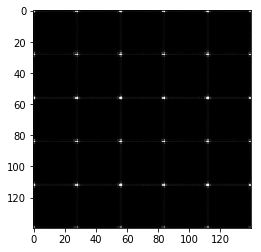

Epoch 1/2  Batch 125  Discriminator Loss: 1.0940  Generator Loss: 0.5763
Epoch 1/2  Batch 150  Discriminator Loss: 0.1581  Generator Loss: 2.4552
Epoch 1/2  Batch 175  Discriminator Loss: 0.0656  Generator Loss: 3.2078
Epoch 1/2  Batch 200  Discriminator Loss: 1.2283  Generator Loss: 6.1042


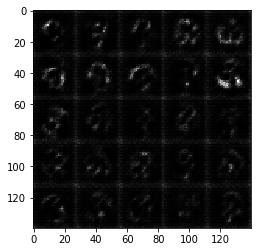

Epoch 1/2  Batch 225  Discriminator Loss: 0.4199  Generator Loss: 1.2288
Epoch 1/2  Batch 250  Discriminator Loss: 0.0135  Generator Loss: 10.3645
Epoch 1/2  Batch 275  Discriminator Loss: 2.3532  Generator Loss: 0.1606
Epoch 1/2  Batch 300  Discriminator Loss: 0.2234  Generator Loss: 2.0885


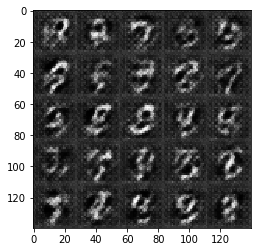

Epoch 1/2  Batch 325  Discriminator Loss: 0.0132  Generator Loss: 4.9423
Epoch 1/2  Batch 350  Discriminator Loss: 0.0226  Generator Loss: 8.7477
Epoch 1/2  Batch 375  Discriminator Loss: 0.1381  Generator Loss: 2.5729
Epoch 1/2  Batch 400  Discriminator Loss: 0.3894  Generator Loss: 4.4840


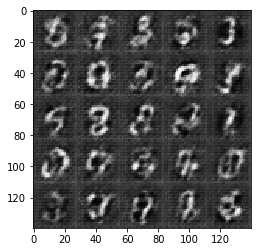

Epoch 1/2  Batch 425  Discriminator Loss: 0.0660  Generator Loss: 5.0596
Epoch 1/2  Batch 450  Discriminator Loss: 0.0116  Generator Loss: 5.2074
Epoch 1/2  Batch 475  Discriminator Loss: 0.7748  Generator Loss: 1.2206
Epoch 1/2  Batch 500  Discriminator Loss: 0.4160  Generator Loss: 1.4587


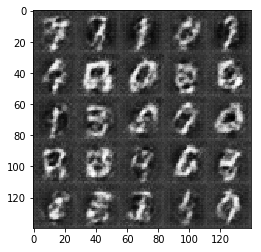

Epoch 1/2  Batch 525  Discriminator Loss: 0.4284  Generator Loss: 1.2618
Epoch 1/2  Batch 550  Discriminator Loss: 0.2421  Generator Loss: 2.4061
Epoch 1/2  Batch 575  Discriminator Loss: 0.2580  Generator Loss: 1.9681
Epoch 1/2  Batch 600  Discriminator Loss: 0.0289  Generator Loss: 4.6417


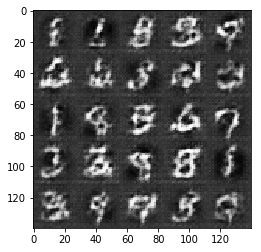

Epoch 1/2  Batch 625  Discriminator Loss: 0.0424  Generator Loss: 5.0742
Epoch 1/2  Batch 650  Discriminator Loss: 0.0201  Generator Loss: 4.6587
Epoch 1/2  Batch 675  Discriminator Loss: 0.6740  Generator Loss: 1.9318
Epoch 1/2  Batch 700  Discriminator Loss: 0.1997  Generator Loss: 2.3376


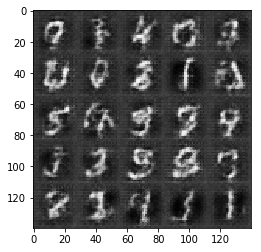

Epoch 1/2  Batch 725  Discriminator Loss: 0.0978  Generator Loss: 3.2819
Epoch 1/2  Batch 750  Discriminator Loss: 0.0450  Generator Loss: 5.0707
Epoch 1/2  Batch 775  Discriminator Loss: 0.0434  Generator Loss: 5.7984
Epoch 1/2  Batch 800  Discriminator Loss: 0.0444  Generator Loss: 4.0224


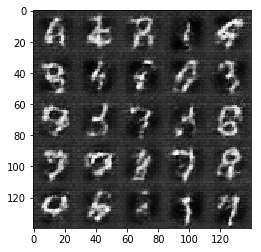

Epoch 1/2  Batch 825  Discriminator Loss: 0.9652  Generator Loss: 0.7001
Epoch 1/2  Batch 850  Discriminator Loss: 0.3191  Generator Loss: 2.7347
Epoch 1/2  Batch 875  Discriminator Loss: 0.5981  Generator Loss: 1.0489
Epoch 1/2  Batch 900  Discriminator Loss: 0.2116  Generator Loss: 2.3183


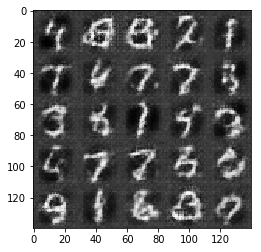

Epoch 1/2  Batch 925  Discriminator Loss: 0.0330  Generator Loss: 4.3891
Epoch 2/2  Batch 25  Discriminator Loss: 0.1548  Generator Loss: 2.3039
Epoch 2/2  Batch 50  Discriminator Loss: 0.0072  Generator Loss: 6.2195
Epoch 2/2  Batch 75  Discriminator Loss: 0.1185  Generator Loss: 2.5094
Epoch 2/2  Batch 100  Discriminator Loss: 0.0373  Generator Loss: 3.8314


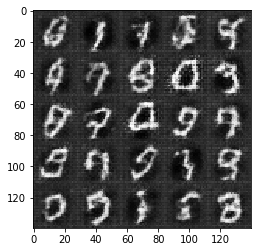

Epoch 2/2  Batch 125  Discriminator Loss: 0.0170  Generator Loss: 5.0844
Epoch 2/2  Batch 150  Discriminator Loss: 0.7218  Generator Loss: 1.0776
Epoch 2/2  Batch 175  Discriminator Loss: 0.8364  Generator Loss: 3.6539
Epoch 2/2  Batch 200  Discriminator Loss: 0.1744  Generator Loss: 2.1479


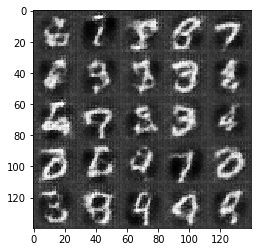

Epoch 2/2  Batch 225  Discriminator Loss: 0.0624  Generator Loss: 3.4213
Epoch 2/2  Batch 250  Discriminator Loss: 0.0304  Generator Loss: 4.1636
Epoch 2/2  Batch 275  Discriminator Loss: 0.8856  Generator Loss: 0.7587
Epoch 2/2  Batch 300  Discriminator Loss: 0.6777  Generator Loss: 1.2025


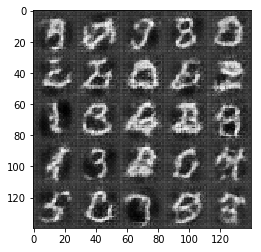

Epoch 2/2  Batch 325  Discriminator Loss: 1.0060  Generator Loss: 0.6272
Epoch 2/2  Batch 350  Discriminator Loss: 0.1116  Generator Loss: 4.6016
Epoch 2/2  Batch 375  Discriminator Loss: 0.3522  Generator Loss: 2.2828
Epoch 2/2  Batch 400  Discriminator Loss: 0.1389  Generator Loss: 2.6179


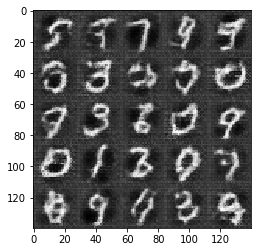

Epoch 2/2  Batch 425  Discriminator Loss: 0.1985  Generator Loss: 2.0578
Epoch 2/2  Batch 450  Discriminator Loss: 0.3862  Generator Loss: 1.4237
Epoch 2/2  Batch 475  Discriminator Loss: 0.1815  Generator Loss: 2.1587
Epoch 2/2  Batch 500  Discriminator Loss: 0.0285  Generator Loss: 4.6488


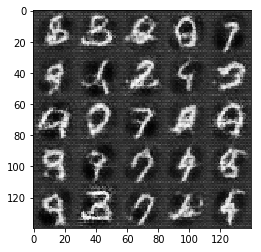

Epoch 2/2  Batch 525  Discriminator Loss: 0.0072  Generator Loss: 7.4427
Epoch 2/2  Batch 550  Discriminator Loss: 0.0069  Generator Loss: 7.4963
Epoch 2/2  Batch 575  Discriminator Loss: 0.0446  Generator Loss: 3.7382
Epoch 2/2  Batch 600  Discriminator Loss: 4.5201  Generator Loss: 4.2991


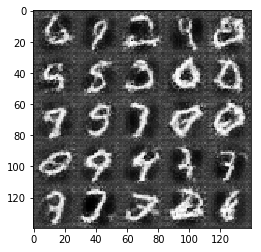

Epoch 2/2  Batch 625  Discriminator Loss: 1.1461  Generator Loss: 0.5067
Epoch 2/2  Batch 650  Discriminator Loss: 0.0522  Generator Loss: 4.2101
Epoch 2/2  Batch 675  Discriminator Loss: 0.1327  Generator Loss: 2.7886
Epoch 2/2  Batch 700  Discriminator Loss: 0.3936  Generator Loss: 3.9473


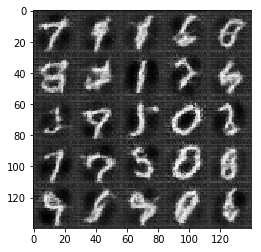

Epoch 2/2  Batch 725  Discriminator Loss: 0.0191  Generator Loss: 7.0396
Epoch 2/2  Batch 750  Discriminator Loss: 0.0590  Generator Loss: 3.5812
Epoch 2/2  Batch 775  Discriminator Loss: 0.2589  Generator Loss: 1.7454
Epoch 2/2  Batch 800  Discriminator Loss: 0.0191  Generator Loss: 6.1746


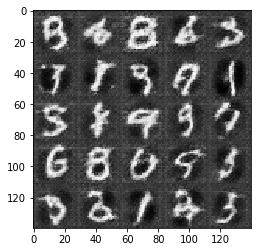

Epoch 2/2  Batch 825  Discriminator Loss: 0.0616  Generator Loss: 3.7604
Epoch 2/2  Batch 850  Discriminator Loss: 0.0449  Generator Loss: 5.8407
Epoch 2/2  Batch 875  Discriminator Loss: 0.0063  Generator Loss: 7.3273
Epoch 2/2  Batch 900  Discriminator Loss: 0.0027  Generator Loss: 8.9896


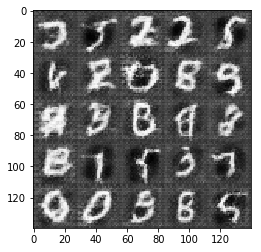

Epoch 2/2  Batch 925  Discriminator Loss: 0.0027  Generator Loss: 13.1203


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002 #Tried 0.002 and 0.001 - performed much worse
beta1 = 0.5 #Same as the DCGAN paper


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2  Batch 25  Discriminator Loss: 0.0552  Generator Loss: 7.2567
Epoch 1/2  Batch 50  Discriminator Loss: 0.0200  Generator Loss: 5.6926
Epoch 1/2  Batch 75  Discriminator Loss: 0.3480  Generator Loss: 3.1320
Epoch 1/2  Batch 100  Discriminator Loss: 0.2563  Generator Loss: 1.9675


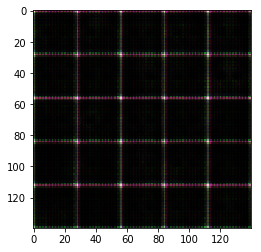

Epoch 1/2  Batch 125  Discriminator Loss: 0.0151  Generator Loss: 6.9997
Epoch 1/2  Batch 150  Discriminator Loss: 0.1035  Generator Loss: 8.2204
Epoch 1/2  Batch 175  Discriminator Loss: 0.0504  Generator Loss: 4.5783
Epoch 1/2  Batch 200  Discriminator Loss: 0.0074  Generator Loss: 12.2096


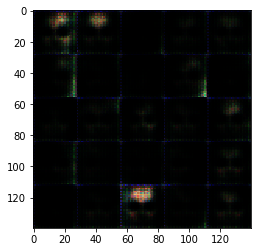

Epoch 1/2  Batch 225  Discriminator Loss: 0.0142  Generator Loss: 15.7816
Epoch 1/2  Batch 250  Discriminator Loss: 0.0227  Generator Loss: 15.4770
Epoch 1/2  Batch 275  Discriminator Loss: 2.9050  Generator Loss: 16.2715
Epoch 1/2  Batch 300  Discriminator Loss: 0.1089  Generator Loss: 3.7020


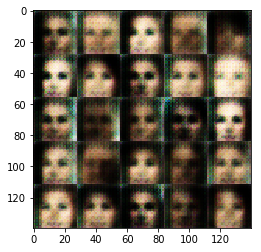

Epoch 1/2  Batch 325  Discriminator Loss: 0.0061  Generator Loss: 11.5026
Epoch 1/2  Batch 350  Discriminator Loss: 0.0451  Generator Loss: 4.4075
Epoch 1/2  Batch 375  Discriminator Loss: 0.0249  Generator Loss: 6.7370
Epoch 1/2  Batch 400  Discriminator Loss: 0.4140  Generator Loss: 2.9243


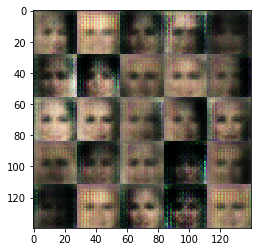

Epoch 1/2  Batch 425  Discriminator Loss: 0.1206  Generator Loss: 3.3551
Epoch 1/2  Batch 450  Discriminator Loss: 0.8166  Generator Loss: 1.3383
Epoch 1/2  Batch 475  Discriminator Loss: 0.1221  Generator Loss: 3.3687
Epoch 1/2  Batch 500  Discriminator Loss: 0.0077  Generator Loss: 6.9046


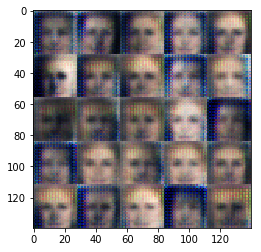

Epoch 1/2  Batch 525  Discriminator Loss: 0.0443  Generator Loss: 6.0105
Epoch 1/2  Batch 550  Discriminator Loss: 0.0137  Generator Loss: 5.2093
Epoch 1/2  Batch 575  Discriminator Loss: 0.0488  Generator Loss: 3.8467
Epoch 1/2  Batch 600  Discriminator Loss: 0.2596  Generator Loss: 1.8130


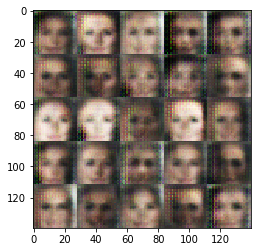

Epoch 1/2  Batch 625  Discriminator Loss: 0.0190  Generator Loss: 6.3280
Epoch 1/2  Batch 650  Discriminator Loss: 0.1993  Generator Loss: 6.7738
Epoch 1/2  Batch 675  Discriminator Loss: 0.0544  Generator Loss: 10.8943
Epoch 1/2  Batch 700  Discriminator Loss: 0.0770  Generator Loss: 3.4371


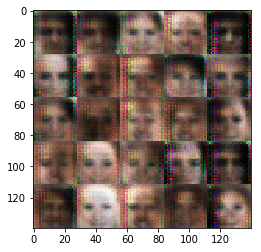

Epoch 1/2  Batch 725  Discriminator Loss: 0.3581  Generator Loss: 1.7760
Epoch 1/2  Batch 750  Discriminator Loss: 0.0634  Generator Loss: 3.5441
Epoch 1/2  Batch 775  Discriminator Loss: 0.0015  Generator Loss: 9.9653
Epoch 1/2  Batch 800  Discriminator Loss: 0.0088  Generator Loss: 7.1939


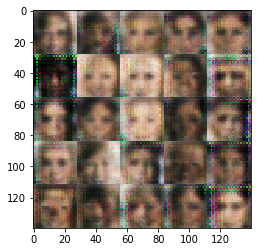

Epoch 1/2  Batch 825  Discriminator Loss: 0.0015  Generator Loss: 13.6943
Epoch 1/2  Batch 850  Discriminator Loss: 0.3608  Generator Loss: 1.9131
Epoch 1/2  Batch 875  Discriminator Loss: 0.0043  Generator Loss: 9.7027
Epoch 1/2  Batch 900  Discriminator Loss: 0.0124  Generator Loss: 5.7647


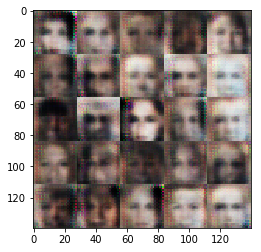

Epoch 1/2  Batch 925  Discriminator Loss: 0.0362  Generator Loss: 10.4262
Epoch 1/2  Batch 950  Discriminator Loss: 0.2487  Generator Loss: 2.0449
Epoch 1/2  Batch 975  Discriminator Loss: 0.7072  Generator Loss: 1.0316
Epoch 1/2  Batch 1000  Discriminator Loss: 1.7376  Generator Loss: 0.8027


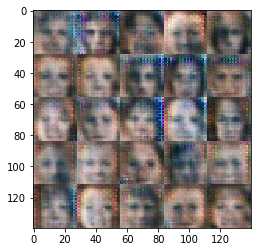

Epoch 1/2  Batch 1025  Discriminator Loss: 1.3694  Generator Loss: 0.5379
Epoch 1/2  Batch 1050  Discriminator Loss: 0.0130  Generator Loss: 7.8698
Epoch 1/2  Batch 1075  Discriminator Loss: 0.5444  Generator Loss: 1.5031
Epoch 1/2  Batch 1100  Discriminator Loss: 0.0019  Generator Loss: 8.3737


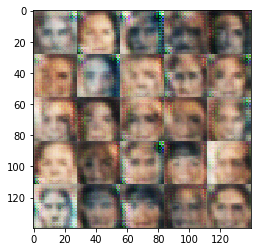

Epoch 1/2  Batch 1125  Discriminator Loss: 0.0238  Generator Loss: 4.6863
Epoch 1/2  Batch 1150  Discriminator Loss: 0.0335  Generator Loss: 4.3175
Epoch 1/2  Batch 1175  Discriminator Loss: 2.5681  Generator Loss: 0.5311
Epoch 1/2  Batch 1200  Discriminator Loss: 1.0031  Generator Loss: 0.8962


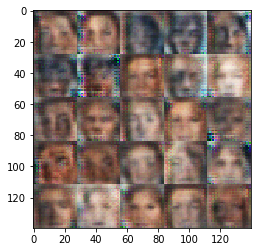

Epoch 1/2  Batch 1225  Discriminator Loss: 1.2083  Generator Loss: 1.0275
Epoch 1/2  Batch 1250  Discriminator Loss: 1.3002  Generator Loss: 0.5766
Epoch 1/2  Batch 1275  Discriminator Loss: 0.8789  Generator Loss: 1.2922
Epoch 1/2  Batch 1300  Discriminator Loss: 1.2095  Generator Loss: 0.5954


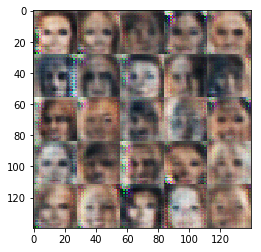

Epoch 1/2  Batch 1325  Discriminator Loss: 0.3209  Generator Loss: 1.7891
Epoch 1/2  Batch 1350  Discriminator Loss: 0.3466  Generator Loss: 1.8661
Epoch 1/2  Batch 1375  Discriminator Loss: 0.0285  Generator Loss: 7.8492
Epoch 1/2  Batch 1400  Discriminator Loss: 0.0117  Generator Loss: 8.0339


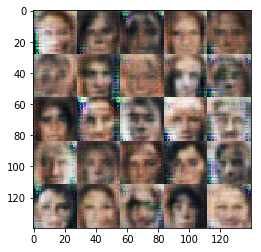

Epoch 1/2  Batch 1425  Discriminator Loss: 0.0164  Generator Loss: 5.3662
Epoch 1/2  Batch 1450  Discriminator Loss: 0.0856  Generator Loss: 3.2581
Epoch 1/2  Batch 1475  Discriminator Loss: 0.2143  Generator Loss: 2.5662
Epoch 1/2  Batch 1500  Discriminator Loss: 0.5647  Generator Loss: 1.1792


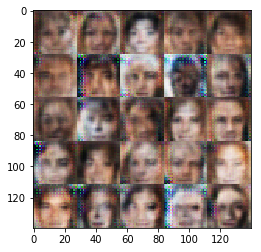

Epoch 1/2  Batch 1525  Discriminator Loss: 1.3836  Generator Loss: 0.4637
Epoch 1/2  Batch 1550  Discriminator Loss: 0.0135  Generator Loss: 8.9799
Epoch 1/2  Batch 1575  Discriminator Loss: 0.0474  Generator Loss: 4.9434
Epoch 1/2  Batch 1600  Discriminator Loss: 1.8291  Generator Loss: 0.9877


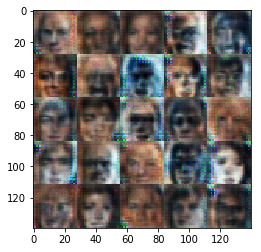

Epoch 1/2  Batch 1625  Discriminator Loss: 0.0614  Generator Loss: 4.4346
Epoch 1/2  Batch 1650  Discriminator Loss: 0.7904  Generator Loss: 5.6658
Epoch 1/2  Batch 1675  Discriminator Loss: 0.3488  Generator Loss: 1.5015
Epoch 1/2  Batch 1700  Discriminator Loss: 1.7585  Generator Loss: 0.3169


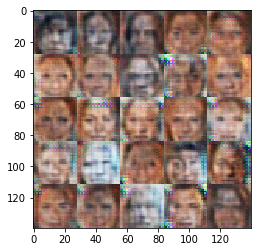

Epoch 1/2  Batch 1725  Discriminator Loss: 1.5515  Generator Loss: 2.1828
Epoch 1/2  Batch 1750  Discriminator Loss: 1.2140  Generator Loss: 0.4864
Epoch 1/2  Batch 1775  Discriminator Loss: 0.4643  Generator Loss: 1.2405
Epoch 1/2  Batch 1800  Discriminator Loss: 0.1261  Generator Loss: 3.9132


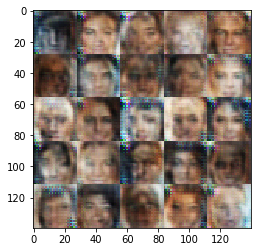

Epoch 1/2  Batch 1825  Discriminator Loss: 0.1690  Generator Loss: 3.7065
Epoch 1/2  Batch 1850  Discriminator Loss: 2.7980  Generator Loss: 0.1014
Epoch 1/2  Batch 1875  Discriminator Loss: 1.1787  Generator Loss: 1.2582
Epoch 1/2  Batch 1900  Discriminator Loss: 0.0896  Generator Loss: 5.4295


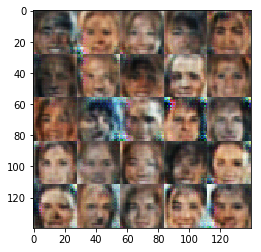

Epoch 1/2  Batch 1925  Discriminator Loss: 0.6992  Generator Loss: 1.2015
Epoch 1/2  Batch 1950  Discriminator Loss: 0.7112  Generator Loss: 1.0529
Epoch 1/2  Batch 1975  Discriminator Loss: 1.1908  Generator Loss: 0.5858
Epoch 1/2  Batch 2000  Discriminator Loss: 0.2912  Generator Loss: 1.9906


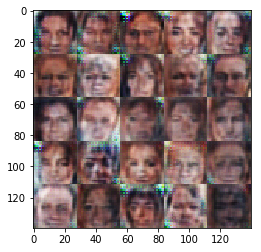

Epoch 1/2  Batch 2025  Discriminator Loss: 0.4695  Generator Loss: 2.0337
Epoch 1/2  Batch 2050  Discriminator Loss: 2.5634  Generator Loss: 0.1447
Epoch 1/2  Batch 2075  Discriminator Loss: 1.2716  Generator Loss: 0.5669
Epoch 1/2  Batch 2100  Discriminator Loss: 1.1011  Generator Loss: 0.6162


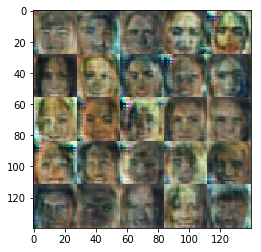

Epoch 1/2  Batch 2125  Discriminator Loss: 0.5631  Generator Loss: 1.7282
Epoch 1/2  Batch 2150  Discriminator Loss: 0.3456  Generator Loss: 1.9884
Epoch 1/2  Batch 2175  Discriminator Loss: 0.2630  Generator Loss: 4.3003
Epoch 1/2  Batch 2200  Discriminator Loss: 0.0415  Generator Loss: 5.8930


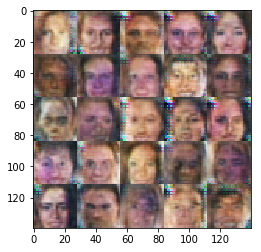

Epoch 1/2  Batch 2225  Discriminator Loss: 1.1185  Generator Loss: 2.8151
Epoch 1/2  Batch 2250  Discriminator Loss: 0.4293  Generator Loss: 2.7029
Epoch 1/2  Batch 2275  Discriminator Loss: 1.1213  Generator Loss: 0.6075
Epoch 1/2  Batch 2300  Discriminator Loss: 0.9582  Generator Loss: 0.7064


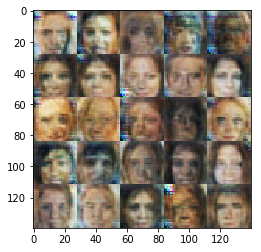

Epoch 1/2  Batch 2325  Discriminator Loss: 1.5286  Generator Loss: 0.3287
Epoch 1/2  Batch 2350  Discriminator Loss: 1.1226  Generator Loss: 0.5349
Epoch 1/2  Batch 2375  Discriminator Loss: 0.7504  Generator Loss: 1.1759
Epoch 1/2  Batch 2400  Discriminator Loss: 0.8764  Generator Loss: 0.9502


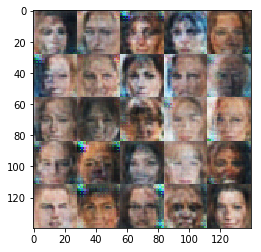

Epoch 1/2  Batch 2425  Discriminator Loss: 0.6010  Generator Loss: 1.4900
Epoch 1/2  Batch 2450  Discriminator Loss: 1.1361  Generator Loss: 0.6833
Epoch 1/2  Batch 2475  Discriminator Loss: 0.8686  Generator Loss: 3.1859
Epoch 1/2  Batch 2500  Discriminator Loss: 0.5946  Generator Loss: 2.7487


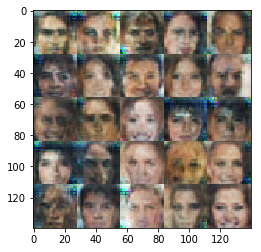

Epoch 1/2  Batch 2525  Discriminator Loss: 1.4921  Generator Loss: 0.3510
Epoch 1/2  Batch 2550  Discriminator Loss: 1.4410  Generator Loss: 3.9255
Epoch 1/2  Batch 2575  Discriminator Loss: 0.5259  Generator Loss: 1.6504
Epoch 1/2  Batch 2600  Discriminator Loss: 0.4554  Generator Loss: 1.5554


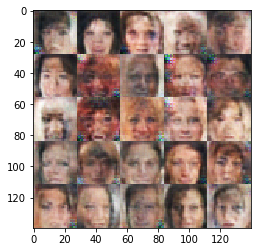

Epoch 1/2  Batch 2625  Discriminator Loss: 1.0985  Generator Loss: 1.4063
Epoch 1/2  Batch 2650  Discriminator Loss: 2.4577  Generator Loss: 0.1194
Epoch 1/2  Batch 2675  Discriminator Loss: 0.4894  Generator Loss: 1.5508
Epoch 1/2  Batch 2700  Discriminator Loss: 1.1713  Generator Loss: 0.6115


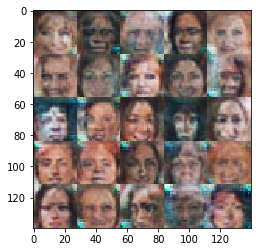

Epoch 1/2  Batch 2725  Discriminator Loss: 1.0089  Generator Loss: 0.7624
Epoch 1/2  Batch 2750  Discriminator Loss: 2.5171  Generator Loss: 0.1847
Epoch 1/2  Batch 2775  Discriminator Loss: 0.3299  Generator Loss: 2.0426
Epoch 1/2  Batch 2800  Discriminator Loss: 1.0362  Generator Loss: 0.6518


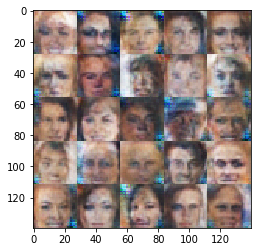

Epoch 1/2  Batch 2825  Discriminator Loss: 0.5177  Generator Loss: 2.5926
Epoch 1/2  Batch 2850  Discriminator Loss: 1.7212  Generator Loss: 0.3382
Epoch 1/2  Batch 2875  Discriminator Loss: 1.7170  Generator Loss: 0.3741
Epoch 1/2  Batch 2900  Discriminator Loss: 0.7625  Generator Loss: 0.8984


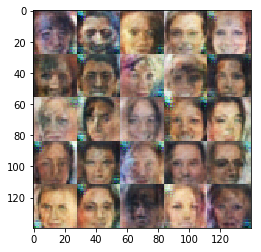

Epoch 1/2  Batch 2925  Discriminator Loss: 0.9549  Generator Loss: 0.7883
Epoch 1/2  Batch 2950  Discriminator Loss: 0.6164  Generator Loss: 1.4424
Epoch 1/2  Batch 2975  Discriminator Loss: 1.0256  Generator Loss: 0.7194
Epoch 1/2  Batch 3000  Discriminator Loss: 1.5636  Generator Loss: 0.3591


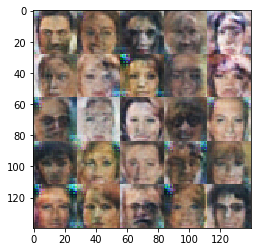

Epoch 1/2  Batch 3025  Discriminator Loss: 0.6711  Generator Loss: 1.1892
Epoch 1/2  Batch 3050  Discriminator Loss: 1.8703  Generator Loss: 2.7797
Epoch 1/2  Batch 3075  Discriminator Loss: 0.9417  Generator Loss: 0.8598
Epoch 1/2  Batch 3100  Discriminator Loss: 1.0110  Generator Loss: 0.6551


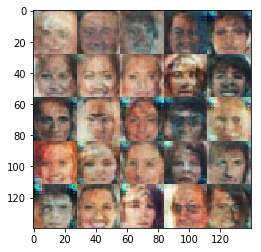

Epoch 1/2  Batch 3125  Discriminator Loss: 1.7278  Generator Loss: 0.2932
Epoch 1/2  Batch 3150  Discriminator Loss: 2.3496  Generator Loss: 0.1736
Epoch 2/2  Batch 25  Discriminator Loss: 2.2314  Generator Loss: 3.7457
Epoch 2/2  Batch 50  Discriminator Loss: 1.2337  Generator Loss: 0.5360
Epoch 2/2  Batch 75  Discriminator Loss: 0.8718  Generator Loss: 1.6156
Epoch 2/2  Batch 100  Discriminator Loss: 0.8985  Generator Loss: 0.7850


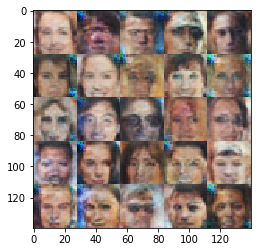

Epoch 2/2  Batch 125  Discriminator Loss: 1.4272  Generator Loss: 0.4850
Epoch 2/2  Batch 150  Discriminator Loss: 1.5519  Generator Loss: 0.3487
Epoch 2/2  Batch 175  Discriminator Loss: 2.4173  Generator Loss: 0.1177
Epoch 2/2  Batch 200  Discriminator Loss: 0.8502  Generator Loss: 1.0626


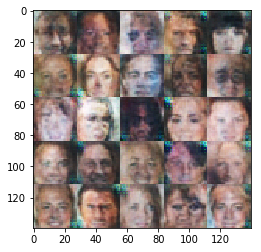

Epoch 2/2  Batch 225  Discriminator Loss: 1.9711  Generator Loss: 0.2002
Epoch 2/2  Batch 250  Discriminator Loss: 0.6143  Generator Loss: 1.9856
Epoch 2/2  Batch 275  Discriminator Loss: 2.9466  Generator Loss: 0.0943
Epoch 2/2  Batch 300  Discriminator Loss: 1.0413  Generator Loss: 0.7415


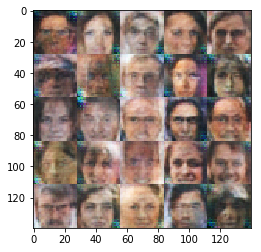

Epoch 2/2  Batch 325  Discriminator Loss: 0.6710  Generator Loss: 1.2451
Epoch 2/2  Batch 350  Discriminator Loss: 0.6531  Generator Loss: 1.0365
Epoch 2/2  Batch 375  Discriminator Loss: 0.7015  Generator Loss: 1.1638
Epoch 2/2  Batch 400  Discriminator Loss: 0.7130  Generator Loss: 1.0477


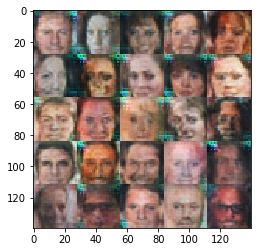

Epoch 2/2  Batch 425  Discriminator Loss: 0.8628  Generator Loss: 3.3828
Epoch 2/2  Batch 450  Discriminator Loss: 1.6239  Generator Loss: 0.3221
Epoch 2/2  Batch 475  Discriminator Loss: 0.9027  Generator Loss: 0.9277
Epoch 2/2  Batch 500  Discriminator Loss: 1.6976  Generator Loss: 0.3294


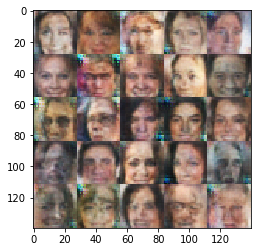

Epoch 2/2  Batch 525  Discriminator Loss: 2.4359  Generator Loss: 0.1411
Epoch 2/2  Batch 550  Discriminator Loss: 1.2081  Generator Loss: 0.5317
Epoch 2/2  Batch 575  Discriminator Loss: 1.0074  Generator Loss: 0.7097
Epoch 2/2  Batch 600  Discriminator Loss: 0.6685  Generator Loss: 1.1494


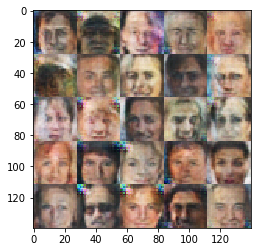

Epoch 2/2  Batch 625  Discriminator Loss: 1.3131  Generator Loss: 0.4834
Epoch 2/2  Batch 650  Discriminator Loss: 0.5145  Generator Loss: 1.3659
Epoch 2/2  Batch 675  Discriminator Loss: 0.9460  Generator Loss: 0.7751
Epoch 2/2  Batch 700  Discriminator Loss: 1.3164  Generator Loss: 0.4435


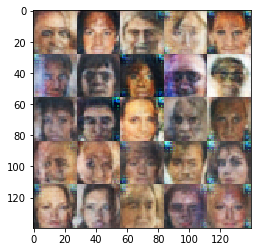

Epoch 2/2  Batch 725  Discriminator Loss: 0.7348  Generator Loss: 1.0911
Epoch 2/2  Batch 750  Discriminator Loss: 1.2115  Generator Loss: 0.5074
Epoch 2/2  Batch 775  Discriminator Loss: 1.1079  Generator Loss: 0.6669
Epoch 2/2  Batch 800  Discriminator Loss: 0.8997  Generator Loss: 0.8389


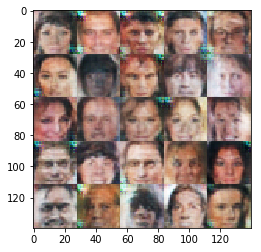

Epoch 2/2  Batch 825  Discriminator Loss: 1.3784  Generator Loss: 0.4199
Epoch 2/2  Batch 850  Discriminator Loss: 0.9005  Generator Loss: 0.9046
Epoch 2/2  Batch 875  Discriminator Loss: 0.5634  Generator Loss: 1.3622
Epoch 2/2  Batch 900  Discriminator Loss: 1.7056  Generator Loss: 0.3134


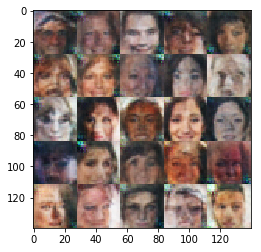

Epoch 2/2  Batch 925  Discriminator Loss: 0.7355  Generator Loss: 1.1096
Epoch 2/2  Batch 950  Discriminator Loss: 1.5807  Generator Loss: 0.3547
Epoch 2/2  Batch 975  Discriminator Loss: 0.9092  Generator Loss: 0.9561
Epoch 2/2  Batch 1000  Discriminator Loss: 0.9060  Generator Loss: 2.1684


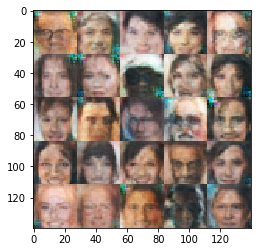

Epoch 2/2  Batch 1025  Discriminator Loss: 2.0517  Generator Loss: 0.1959
Epoch 2/2  Batch 1050  Discriminator Loss: 2.1615  Generator Loss: 0.1690
Epoch 2/2  Batch 1075  Discriminator Loss: 0.8458  Generator Loss: 0.9198
Epoch 2/2  Batch 1100  Discriminator Loss: 1.3711  Generator Loss: 0.4934


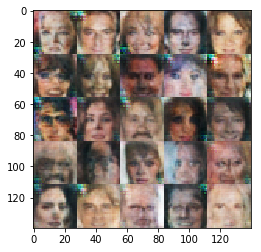

Epoch 2/2  Batch 1125  Discriminator Loss: 1.3086  Generator Loss: 0.4238
Epoch 2/2  Batch 1150  Discriminator Loss: 0.9943  Generator Loss: 0.7414
Epoch 2/2  Batch 1175  Discriminator Loss: 1.1710  Generator Loss: 0.6027
Epoch 2/2  Batch 1200  Discriminator Loss: 0.3647  Generator Loss: 4.0762


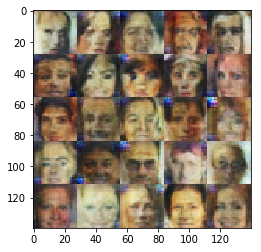

Epoch 2/2  Batch 1225  Discriminator Loss: 0.9741  Generator Loss: 0.7075
Epoch 2/2  Batch 1250  Discriminator Loss: 1.2378  Generator Loss: 0.5181
Epoch 2/2  Batch 1275  Discriminator Loss: 1.3286  Generator Loss: 0.4425
Epoch 2/2  Batch 1300  Discriminator Loss: 2.2937  Generator Loss: 2.9634


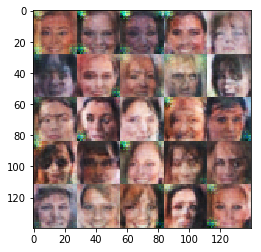

Epoch 2/2  Batch 1325  Discriminator Loss: 0.8340  Generator Loss: 1.1368
Epoch 2/2  Batch 1350  Discriminator Loss: 1.2442  Generator Loss: 0.5531
Epoch 2/2  Batch 1375  Discriminator Loss: 1.1343  Generator Loss: 0.7645
Epoch 2/2  Batch 1400  Discriminator Loss: 0.9918  Generator Loss: 1.2856


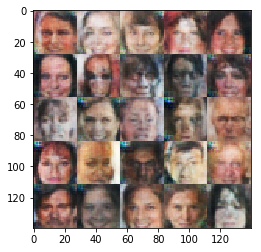

Epoch 2/2  Batch 1425  Discriminator Loss: 2.2206  Generator Loss: 0.1641
Epoch 2/2  Batch 1450  Discriminator Loss: 0.6652  Generator Loss: 1.3045
Epoch 2/2  Batch 1475  Discriminator Loss: 1.4074  Generator Loss: 0.4390
Epoch 2/2  Batch 1500  Discriminator Loss: 1.3469  Generator Loss: 0.4185


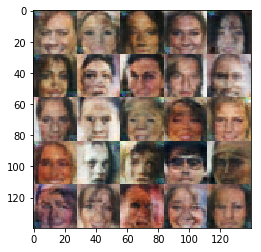

Epoch 2/2  Batch 1525  Discriminator Loss: 0.7615  Generator Loss: 1.2750
Epoch 2/2  Batch 1550  Discriminator Loss: 0.8825  Generator Loss: 1.4193
Epoch 2/2  Batch 1575  Discriminator Loss: 0.6845  Generator Loss: 1.4589
Epoch 2/2  Batch 1600  Discriminator Loss: 0.0168  Generator Loss: 7.8949


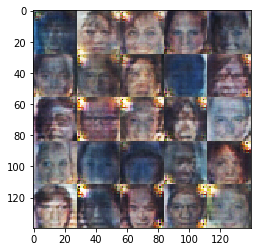

Epoch 2/2  Batch 1625  Discriminator Loss: 1.3585  Generator Loss: 0.4959
Epoch 2/2  Batch 1650  Discriminator Loss: 1.3379  Generator Loss: 0.4713
Epoch 2/2  Batch 1675  Discriminator Loss: 0.5455  Generator Loss: 1.4637
Epoch 2/2  Batch 1700  Discriminator Loss: 0.9841  Generator Loss: 0.7720


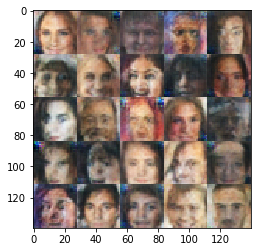

Epoch 2/2  Batch 1725  Discriminator Loss: 1.0649  Generator Loss: 0.6671
Epoch 2/2  Batch 1750  Discriminator Loss: 1.8356  Generator Loss: 0.2237
Epoch 2/2  Batch 1775  Discriminator Loss: 2.1088  Generator Loss: 0.1730
Epoch 2/2  Batch 1800  Discriminator Loss: 0.8556  Generator Loss: 0.8269


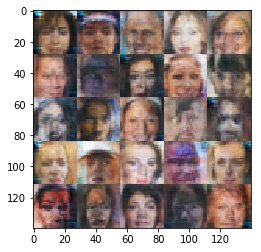

Epoch 2/2  Batch 1825  Discriminator Loss: 1.2673  Generator Loss: 0.4874
Epoch 2/2  Batch 1850  Discriminator Loss: 0.9694  Generator Loss: 0.8416
Epoch 2/2  Batch 1875  Discriminator Loss: 1.3736  Generator Loss: 0.4250
Epoch 2/2  Batch 1900  Discriminator Loss: 1.4245  Generator Loss: 0.3927


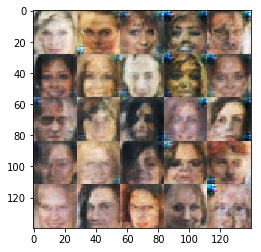

Epoch 2/2  Batch 1925  Discriminator Loss: 2.0566  Generator Loss: 0.2366
Epoch 2/2  Batch 1950  Discriminator Loss: 0.7970  Generator Loss: 1.5005
Epoch 2/2  Batch 1975  Discriminator Loss: 1.3032  Generator Loss: 0.4922
Epoch 2/2  Batch 2000  Discriminator Loss: 1.3833  Generator Loss: 0.4203


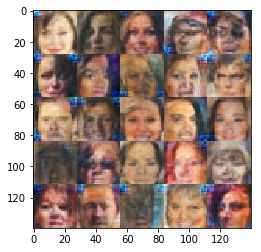

Epoch 2/2  Batch 2025  Discriminator Loss: 1.1598  Generator Loss: 2.6436
Epoch 2/2  Batch 2050  Discriminator Loss: 1.1938  Generator Loss: 0.5730
Epoch 2/2  Batch 2075  Discriminator Loss: 0.4655  Generator Loss: 1.7066
Epoch 2/2  Batch 2100  Discriminator Loss: 2.7288  Generator Loss: 0.0967


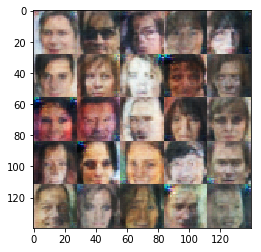

Epoch 2/2  Batch 2125  Discriminator Loss: 0.7432  Generator Loss: 0.9425
Epoch 2/2  Batch 2150  Discriminator Loss: 1.4824  Generator Loss: 0.4085
Epoch 2/2  Batch 2175  Discriminator Loss: 0.2709  Generator Loss: 3.8403
Epoch 2/2  Batch 2200  Discriminator Loss: 2.0777  Generator Loss: 7.2731


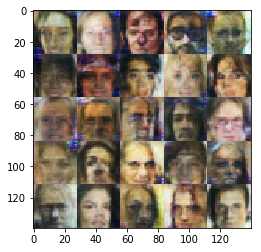

Epoch 2/2  Batch 2225  Discriminator Loss: 0.5014  Generator Loss: 1.4159
Epoch 2/2  Batch 2250  Discriminator Loss: 2.1693  Generator Loss: 0.1894
Epoch 2/2  Batch 2275  Discriminator Loss: 0.8307  Generator Loss: 1.1434
Epoch 2/2  Batch 2300  Discriminator Loss: 2.8451  Generator Loss: 0.0853


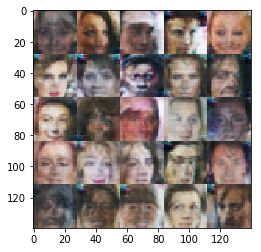

Epoch 2/2  Batch 2325  Discriminator Loss: 1.5244  Generator Loss: 0.4114
Epoch 2/2  Batch 2350  Discriminator Loss: 0.1135  Generator Loss: 4.1333
Epoch 2/2  Batch 2375  Discriminator Loss: 1.2813  Generator Loss: 0.6005
Epoch 2/2  Batch 2400  Discriminator Loss: 0.6549  Generator Loss: 1.3220


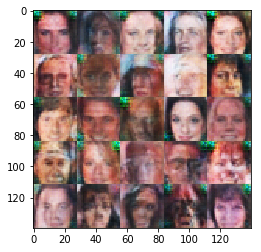

Epoch 2/2  Batch 2425  Discriminator Loss: 0.6232  Generator Loss: 1.6503
Epoch 2/2  Batch 2450  Discriminator Loss: 0.5694  Generator Loss: 1.5850
Epoch 2/2  Batch 2475  Discriminator Loss: 2.5238  Generator Loss: 0.1339
Epoch 2/2  Batch 2500  Discriminator Loss: 0.3488  Generator Loss: 2.0985


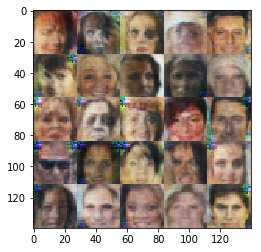

Epoch 2/2  Batch 2525  Discriminator Loss: 1.0577  Generator Loss: 0.6546
Epoch 2/2  Batch 2550  Discriminator Loss: 0.7640  Generator Loss: 1.1869
Epoch 2/2  Batch 2575  Discriminator Loss: 0.6396  Generator Loss: 1.2898
Epoch 2/2  Batch 2600  Discriminator Loss: 0.1281  Generator Loss: 4.0585


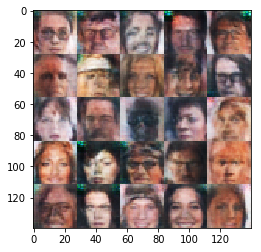

Epoch 2/2  Batch 2625  Discriminator Loss: 0.9969  Generator Loss: 0.6829
Epoch 2/2  Batch 2650  Discriminator Loss: 2.0366  Generator Loss: 0.1925
Epoch 2/2  Batch 2675  Discriminator Loss: 0.4876  Generator Loss: 1.4936
Epoch 2/2  Batch 2700  Discriminator Loss: 0.5929  Generator Loss: 1.4012


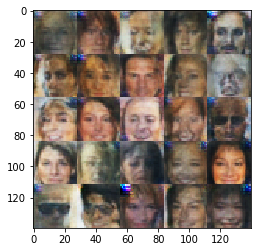

Epoch 2/2  Batch 2725  Discriminator Loss: 0.8290  Generator Loss: 0.7783
Epoch 2/2  Batch 2750  Discriminator Loss: 1.7788  Generator Loss: 0.2813
Epoch 2/2  Batch 2775  Discriminator Loss: 1.3840  Generator Loss: 0.4346
Epoch 2/2  Batch 2800  Discriminator Loss: 1.2309  Generator Loss: 0.5154


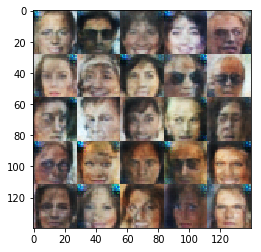

Epoch 2/2  Batch 2825  Discriminator Loss: 0.8103  Generator Loss: 2.8338
Epoch 2/2  Batch 2850  Discriminator Loss: 2.0957  Generator Loss: 0.2028
Epoch 2/2  Batch 2875  Discriminator Loss: 0.4709  Generator Loss: 1.2297
Epoch 2/2  Batch 2900  Discriminator Loss: 0.9759  Generator Loss: 0.6929


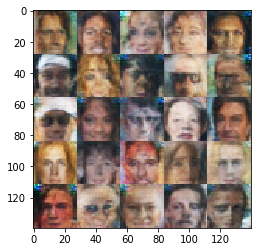

Epoch 2/2  Batch 2925  Discriminator Loss: 0.8594  Generator Loss: 0.8412
Epoch 2/2  Batch 2950  Discriminator Loss: 0.7855  Generator Loss: 0.9095
Epoch 2/2  Batch 2975  Discriminator Loss: 0.7955  Generator Loss: 0.9298
Epoch 2/2  Batch 3000  Discriminator Loss: 1.4881  Generator Loss: 0.3986


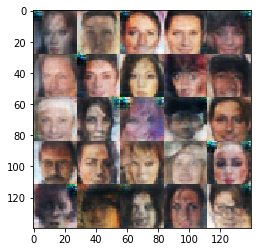

Epoch 2/2  Batch 3025  Discriminator Loss: 1.0528  Generator Loss: 0.8030
Epoch 2/2  Batch 3050  Discriminator Loss: 0.4709  Generator Loss: 2.9675
Epoch 2/2  Batch 3075  Discriminator Loss: 1.0770  Generator Loss: 0.5751
Epoch 2/2  Batch 3100  Discriminator Loss: 1.6508  Generator Loss: 0.3104


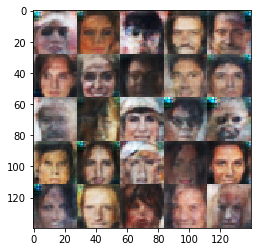

Epoch 2/2  Batch 3125  Discriminator Loss: 0.9461  Generator Loss: 0.8165
Epoch 2/2  Batch 3150  Discriminator Loss: 1.4739  Generator Loss: 0.3496


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.